In [1]:
!python -V

Python 3.9.0


In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### set up mlflow-uri

To run this file we need to launch the mlflow server locally by running the following command in your terminal in main(root) directory:

`mlflow ui --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns`

it will create `mflow.db` and `mlruns` directory in root directory and the mlflow will server on the given link:
`http://127.0.0.1:5000/`

In [3]:
import mlflow
TRACCKING_URI = "http://127.0.0.1:5000/"
mlflow.set_tracking_uri(TRACCKING_URI)

In [4]:
# set-up mflow experiment
mlflow.set_experiment("store-sales-prediction")

<Experiment: artifact_location='/home/mshifa/workspace/zoomcamp/repo_clone/mlops_projects/mlruns/1', creation_time=1753723131801, experiment_id='1', last_update_time=1753723131801, lifecycle_stage='active', name='store-sales-prediction', tags={}>

In [5]:
# read the csv file
def read_dataframe(filename):
    df = pd.read_csv(filename)
    
    return df
    

In [6]:
# dataframe feature engineering
def feature_engineering(df):
    df["date"] = pd.to_datetime(df["date"])
    
    # Feature Engineering — Date-based features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

    # Define categorical features
    categorical = ["store", "promo", "holiday", "year", "month", "dayofweek", "is_weekend"]
    df_dicts = df[categorical].to_dict(orient="records")

    return df_dicts

In [7]:
# load and read datasets
train_df = read_dataframe("./input_data/train.csv")
test_df = read_dataframe("./input_data/test.csv")
print(train_df.shape)
print(test_df.shape)

(5840, 5)
(1460, 5)


In [8]:
# feature_engineering
train_dicts = feature_engineering(train_df)

test_dicts = feature_engineering(test_df)
print(len(test_dicts))

1460


In [9]:
# transform with DictVectorizer
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)

X_test = dv.transform(test_dicts)

# Target from dataframe
y_train = train_df["sales"].values
y_test = test_df["sales"].values

In [10]:
print(X_train.shape)
print(X_test.shape)

(5840, 7)
(1460, 7)


### Train Linear Regression Model

In [11]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# RMSE
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print("RMSE (Linear Regression):", round(rmse_lr, 2))


RMSE (Linear Regression): 13.46


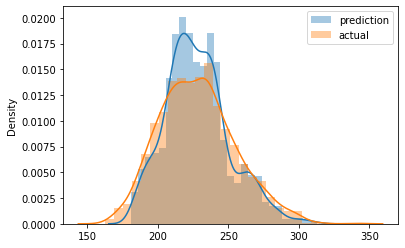

In [12]:
sns.distplot(y_pred_lr, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

In [13]:
# Save both the model and the DictVectorizer
with open("./model/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr_model), f_out)

#saved the preprocessor
with open("./model/preprocessor.b", "wb") as f_out:
    pickle.dump(dv, f_out)

In [14]:
# Load the saved model and DictVectorizer
with open("./model/lin_reg.bin", "rb") as f_in:
    dv_loaded, model_loaded = pickle.load(f_in)

# Example usage with new data (dict format)
new_data = {"store": 1, "promo": 0, "holiday": 0, "year": 2024, "month": 12, "dayofweek": 2, "is_weekend": 0}
X_new = dv_loaded.transform([new_data])
pred = model_loaded.predict(X_new)
print("Predicted Sales:", pred[0])

Predicted Sales: 259.45766222696693


### Train Linear regression and track experiment in mlflow

In [15]:
# Tacking experiment in MLFlow

with mlflow.start_run():
    
    mlflow.set_tag("developer", "moshifa")
    mlflow.log_param("train data path","./input_data/train.csv")
    mlflow.log_param("test data path", "./input_data/test.csv")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred_lasso = lr.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
    mlflow.log_metric("rmse", rmse)
    

🏃 View run bittersweet-mink-546 at: http://127.0.0.1:5000/#/experiments/1/runs/8e2de8939f1140d5958bf96e9a0ff773
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### XGBoost hpyerparameter optimization and tracking in mlfow experiment

In [16]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

In [18]:
def optimize_xgboost_with_mlflow(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(test, 'test')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


In [19]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=optimize_xgboost_with_mlflow,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[22:25:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:186.59860                                                         
[1]	test-rmse:152.06443                                                         
[2]	test-rmse:124.00012                                                         
[3]	test-rmse:101.11424                                                         
[4]	test-rmse:82.49136                                                          
[5]	test-rmse:67.32831                                                          
[6]	test-rmse:54.99399                                                          
[7]	test-rmse:44.97743                                                          
[8]	test-rmse:36.82925                                                          
[9]	test-rmse:30.22234                                                          
[10]	test-rmse:24.87586                                                

[14]	test-rmse:5.98380                                                          
[15]	test-rmse:5.99287                                                          
[16]	test-rmse:6.01700                                                          
[17]	test-rmse:6.04028                                                          
[18]	test-rmse:6.07141                                                          
[19]	test-rmse:6.09398                                                          
[20]	test-rmse:6.12043                                                          
[21]	test-rmse:6.14074                                                          
[22]	test-rmse:6.16078                                                          
[23]	test-rmse:6.18120                                                          
[24]	test-rmse:6.20291                                                          
[25]	test-rmse:6.21877                                                          
[26]	test-rmse:6.23233      

[47]	test-rmse:6.03006                                                          
[48]	test-rmse:6.04006                                                          
[49]	test-rmse:6.05032                                                          
[50]	test-rmse:6.05929                                                          
[51]	test-rmse:6.06447                                                          
[52]	test-rmse:6.07088                                                          
[53]	test-rmse:6.07668                                                          
[54]	test-rmse:6.08112                                                          
[55]	test-rmse:6.08940                                                          
[56]	test-rmse:6.09490                                                          
[57]	test-rmse:6.10563                                                          
[58]	test-rmse:6.11441                                                          
[59]	test-rmse:6.12340      

[71]	test-rmse:6.47492                                                          
[72]	test-rmse:6.47782                                                          
[73]	test-rmse:6.48271                                                          
[74]	test-rmse:6.48510                                                          
[75]	test-rmse:6.48806                                                          
[76]	test-rmse:6.49082                                                          
🏃 View run flawless-mare-579 at: http://127.0.0.1:5000/#/experiments/1/runs/0e16cc518d4d45e1b5c3b1fc2d822148

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:25:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:214.10807                                                         
[1]	test-rmse:200.17737                                                         
[2]	test-rmse:187.15423                   

[91]	test-rmse:6.07594                                                          
[92]	test-rmse:6.07661                                                          
[93]	test-rmse:6.07936                                                          
[94]	test-rmse:6.08112                                                          
[95]	test-rmse:6.08208                                                          
[96]	test-rmse:6.08356                                                          
[97]	test-rmse:6.08348                                                          
[98]	test-rmse:6.08448                                                          
[99]	test-rmse:6.08526                                                          
🏃 View run painted-wren-344 at: http://127.0.0.1:5000/#/experiments/1/runs/6f55cd2ca8b14b61a0c60742584c5254

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:26:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now dep

[88]	test-rmse:5.84376                                                          
[89]	test-rmse:5.84562                                                          
[90]	test-rmse:5.85204                                                          
[91]	test-rmse:5.85599                                                          
[92]	test-rmse:5.85872                                                          
[93]	test-rmse:5.86201                                                          
[94]	test-rmse:5.86305                                                          
[95]	test-rmse:5.86496                                                          
🏃 View run receptive-wren-214 at: http://127.0.0.1:5000/#/experiments/1/runs/c245a0df848740db97a5c5d1ef802d4c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:26:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:214.48533                  

[89]	test-rmse:5.74678                                                          
[90]	test-rmse:5.74746                                                          
[91]	test-rmse:5.74736                                                          
[92]	test-rmse:5.74640                                                          
[93]	test-rmse:5.74621                                                          
[94]	test-rmse:5.74729                                                          
[95]	test-rmse:5.74904                                                          
[96]	test-rmse:5.75131                                                          
[97]	test-rmse:5.75270                                                          
[98]	test-rmse:5.75571                                                          
[99]	test-rmse:5.75706                                                          
🏃 View run inquisitive-lark-758 at: http://127.0.0.1:5000/#/experiments/1/runs/7a41b5ad3cb9426589e61dbd289bde

[86]	test-rmse:6.19346                                                          
[87]	test-rmse:6.15499                                                          
[88]	test-rmse:6.12215                                                          
[89]	test-rmse:6.09191                                                          
[90]	test-rmse:6.06440                                                          
[91]	test-rmse:6.04095                                                          
[92]	test-rmse:6.01850                                                          
[93]	test-rmse:5.99868                                                          
[94]	test-rmse:5.98078                                                          
[95]	test-rmse:5.96466                                                          
[96]	test-rmse:5.95170                                                          
[97]	test-rmse:5.93890                                                          
[98]	test-rmse:5.92670      

[83]	test-rmse:6.67568                                                          
[84]	test-rmse:6.67660                                                          
[85]	test-rmse:6.67880                                                          
[86]	test-rmse:6.68081                                                          
[87]	test-rmse:6.68324                                                          
[88]	test-rmse:6.68543                                                          
[89]	test-rmse:6.68704                                                          
[90]	test-rmse:6.68814                                                          
[91]	test-rmse:6.68896                                                          
[92]	test-rmse:6.68941                                                          
[93]	test-rmse:6.68993                                                          
[94]	test-rmse:6.69042                                                          
[95]	test-rmse:6.69185      

[80]	test-rmse:5.71721                                                          
[81]	test-rmse:5.70006                                                          
[82]	test-rmse:5.68608                                                          
[83]	test-rmse:5.67647                                                          
[84]	test-rmse:5.66133                                                          
[85]	test-rmse:5.64845                                                          
[86]	test-rmse:5.63573                                                          
[87]	test-rmse:5.62643                                                          
[88]	test-rmse:5.61687                                                          
[89]	test-rmse:5.60317                                                          
[90]	test-rmse:5.59627                                                          
[91]	test-rmse:5.58896                                                          
[92]	test-rmse:5.58151      

[16]	test-rmse:8.35413                                                          
[17]	test-rmse:7.62140                                                          
[18]	test-rmse:7.10543                                                          
[19]	test-rmse:6.77297                                                          
[20]	test-rmse:6.56159                                                          
[21]	test-rmse:6.42965                                                          
[22]	test-rmse:6.35496                                                          
[23]	test-rmse:6.31507                                                          
[24]	test-rmse:6.30561                                                          
[25]	test-rmse:6.30054                                                          
[26]	test-rmse:6.30395                                                          
[27]	test-rmse:6.31027                                                          
[28]	test-rmse:6.32937      

[37]	test-rmse:6.62649                                                          
[38]	test-rmse:6.63382                                                          
[39]	test-rmse:6.63828                                                          
[40]	test-rmse:6.64344                                                          
[41]	test-rmse:6.64758                                                          
[42]	test-rmse:6.65254                                                          
[43]	test-rmse:6.65744                                                          
[44]	test-rmse:6.66335                                                          
[45]	test-rmse:6.66489                                                          
[46]	test-rmse:6.66663                                                          
[47]	test-rmse:6.66818                                                          
[48]	test-rmse:6.66925                                                          
[49]	test-rmse:6.67087      

[78]	test-rmse:5.80699                                                          
[79]	test-rmse:5.78563                                                          
[80]	test-rmse:5.76278                                                          
[81]	test-rmse:5.74569                                                          
[82]	test-rmse:5.72890                                                          
[83]	test-rmse:5.71597                                                          
[84]	test-rmse:5.70248                                                          
[85]	test-rmse:5.68962                                                          
[86]	test-rmse:5.68055                                                          
[87]	test-rmse:5.67127                                                          
[88]	test-rmse:5.66291                                                          
[89]	test-rmse:5.65772                                                          
[90]	test-rmse:5.65120      

[16]	test-rmse:94.90139                                                         
[17]	test-rmse:90.12313                                                         
[18]	test-rmse:85.58880                                                         
[19]	test-rmse:81.28372                                                         
[20]	test-rmse:77.19818                                                         
[21]	test-rmse:73.32109                                                         
[22]	test-rmse:69.63631                                                         
[23]	test-rmse:66.14254                                                         
[24]	test-rmse:62.82942                                                         
[25]	test-rmse:59.68172                                                         
[26]	test-rmse:56.69417                                                         
[27]	test-rmse:53.86035                                                         
[28]	test-rmse:51.16702     

[13]	test-rmse:105.61144                                                        
[14]	test-rmse:99.95055                                                         
[15]	test-rmse:94.60025                                                         
[16]	test-rmse:89.52459                                                         
[17]	test-rmse:84.73701                                                         
[18]	test-rmse:80.19707                                                         
[19]	test-rmse:75.91129                                                         
[20]	test-rmse:71.85037                                                         
[21]	test-rmse:68.01633                                                         
[22]	test-rmse:64.38806                                                         
[23]	test-rmse:60.97000                                                         
[24]	test-rmse:57.72661                                                         
[25]	test-rmse:54.66036     

[10]	test-rmse:6.88268                                                          
[11]	test-rmse:6.89162                                                          
[12]	test-rmse:6.90507                                                          
[13]	test-rmse:6.91233                                                          
[14]	test-rmse:6.91238                                                          
[15]	test-rmse:6.91828                                                          
[16]	test-rmse:6.92601                                                          
[17]	test-rmse:6.93034                                                          
[18]	test-rmse:6.93441                                                          
[19]	test-rmse:6.93807                                                          
[20]	test-rmse:6.93973                                                          
[21]	test-rmse:6.93945                                                          
[22]	test-rmse:6.94118      

[55]	test-rmse:6.32157                                                          
[56]	test-rmse:6.32953                                                          
[57]	test-rmse:6.33626                                                          
[58]	test-rmse:6.33861                                                          
[59]	test-rmse:6.34660                                                          
[60]	test-rmse:6.35031                                                          
🏃 View run calm-shrimp-742 at: http://127.0.0.1:5000/#/experiments/1/runs/9afb1080b62849c0a7d4f32d31b40397

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:27:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:186.89051                                                         
[1]	test-rmse:152.53161                                                         
[2]	test-rmse:124.54598                     

[3]	test-rmse:149.67919                                                         
[4]	test-rmse:134.61005                                                         
[5]	test-rmse:121.08007                                                         
[6]	test-rmse:108.96249                                                         
[7]	test-rmse:98.03923                                                          
[8]	test-rmse:88.28165                                                          
[9]	test-rmse:79.48639                                                          
[10]	test-rmse:71.61952                                                         
[11]	test-rmse:64.54563                                                         
[12]	test-rmse:58.24601                                                         
[13]	test-rmse:52.59653                                                         
[14]	test-rmse:47.54107                                                         
[15]	test-rmse:42.94624     

[0]	test-rmse:208.22759                                                         
[1]	test-rmse:189.35019                                                         
[2]	test-rmse:172.18407                                                         
[3]	test-rmse:156.59440                                                         
[4]	test-rmse:142.42940                                                         
[5]	test-rmse:129.54529                                                         
[6]	test-rmse:117.87547                                                         
[7]	test-rmse:107.24529                                                         
[8]	test-rmse:97.59577                                                          
[9]	test-rmse:88.85429                                                          
[10]	test-rmse:80.92529                                                         
[11]	test-rmse:73.67513                                                         
[12]	test-rmse:67.07692     

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:27:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:207.09262                                                         
[1]	test-rmse:187.30593                                                         
[2]	test-rmse:169.42469                                                         
[3]	test-rmse:153.24046                                                         
[4]	test-rmse:138.60016                                                         
[5]	test-rmse:125.37619                                                         
[6]	test-rmse:113.42645                                                         
[7]	test-rmse:102.61669                                                         
[8]	test-rmse:92.83937                                                          
[9]	test-rmse:83.99717                                                 

[98]	test-rmse:5.73628                                                          
[99]	test-rmse:5.73723                                                          
🏃 View run capable-rat-182 at: http://127.0.0.1:5000/#/experiments/1/runs/a7656b89f4414562a74ea5626272a9f3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:27:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:209.09530                                                         
[1]	test-rmse:190.92977                                                         
[2]	test-rmse:174.35063                                                         
[3]	test-rmse:159.21602                                                         
[4]	test-rmse:145.40315                                                         
[5]	test-rmse:132.78937                                                         
[6]	test-rmse:121.27340                     

[95]	test-rmse:6.76882                                                          
[96]	test-rmse:6.76930                                                          
[97]	test-rmse:6.76987                                                          
[98]	test-rmse:6.77033                                                          
[99]	test-rmse:6.77052                                                          
🏃 View run secretive-bear-289 at: http://127.0.0.1:5000/#/experiments/1/runs/5cc9e8db002c4b99a33795366f514b8f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:28:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:198.13101                                                         
[1]	test-rmse:171.43393                                                         
[2]	test-rmse:148.33673                                                         
[3]	test-rmse:128.36609                  

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:28:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:210.24274                                                         
[1]	test-rmse:193.02829                                                         
[2]	test-rmse:177.22866                                                         
[3]	test-rmse:162.72516                                                         
[4]	test-rmse:149.40683                                                         
[5]	test-rmse:137.18904                                                         
[6]	test-rmse:125.97280                                                         
[7]	test-rmse:115.68253                                                         
[8]	test-rmse:106.24110                                                         
[9]	test-rmse:97.57108                                                 

[98]	test-rmse:6.63161                                                          
[99]	test-rmse:6.63305                                                          
🏃 View run delicate-sponge-989 at: http://127.0.0.1:5000/#/experiments/1/runs/7167ec95b6724c65a2a5953b82e3bf05

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:28:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:196.55464                                                         
[1]	test-rmse:168.71902                                                         
[2]	test-rmse:144.83810                                                         
[3]	test-rmse:124.34873                                                         
[4]	test-rmse:106.76111                                                         
[5]	test-rmse:91.68998                                                          
[6]	test-rmse:78.76351                  

[3]	test-rmse:48.76909                                                          
[4]	test-rmse:33.37291                                                          
[5]	test-rmse:23.08057                                                          
[6]	test-rmse:16.28680                                                          
[7]	test-rmse:11.95536                                                          
[8]	test-rmse:9.30913                                                           
[9]	test-rmse:7.78624                                                           
[10]	test-rmse:6.96718                                                          
[11]	test-rmse:6.56223                                                          
[12]	test-rmse:6.38257                                                          
[13]	test-rmse:6.31503                                                          
[14]	test-rmse:6.29374                                                          
[15]	test-rmse:6.29174      

[34]	test-rmse:6.45058                                                          
[35]	test-rmse:6.45302                                                          
[36]	test-rmse:6.45763                                                          
[37]	test-rmse:6.46320                                                          
[38]	test-rmse:6.46978                                                          
[39]	test-rmse:6.47573                                                          
[40]	test-rmse:6.48126                                                          
[41]	test-rmse:6.48963                                                          
[42]	test-rmse:6.49626                                                          
[43]	test-rmse:6.50203                                                          
[44]	test-rmse:6.50760                                                          
[45]	test-rmse:6.51223                                                          
[46]	test-rmse:6.51775      

[48]	test-rmse:6.23967                                                          
[49]	test-rmse:6.24077                                                          
[50]	test-rmse:6.24200                                                          
[51]	test-rmse:6.24499                                                          
[52]	test-rmse:6.25318                                                          
[53]	test-rmse:6.25789                                                          
[54]	test-rmse:6.26381                                                          
[55]	test-rmse:6.26774                                                          
[56]	test-rmse:6.27330                                                          
[57]	test-rmse:6.28195                                                          
[58]	test-rmse:6.28935                                                          
[59]	test-rmse:6.29579                                                          
[60]	test-rmse:6.30287      

[47]	test-rmse:6.68692                                                          
[48]	test-rmse:6.68869                                                          
[49]	test-rmse:6.69088                                                          
[50]	test-rmse:6.69347                                                          
[51]	test-rmse:6.69553                                                          
[52]	test-rmse:6.69680                                                          
[53]	test-rmse:6.69885                                                          
[54]	test-rmse:6.70050                                                          
[55]	test-rmse:6.70183                                                          
[56]	test-rmse:6.70302                                                          
[57]	test-rmse:6.70433                                                          
[58]	test-rmse:6.70564                                                          
[59]	test-rmse:6.70651      

[73]	test-rmse:5.36864                                                          
[74]	test-rmse:5.36521                                                          
[75]	test-rmse:5.36612                                                          
[76]	test-rmse:5.36560                                                          
[77]	test-rmse:5.36820                                                          
[78]	test-rmse:5.36887                                                          
[79]	test-rmse:5.36939                                                          
[80]	test-rmse:5.36663                                                          
[81]	test-rmse:5.36811                                                          
[82]	test-rmse:5.36649                                                          
[83]	test-rmse:5.36564                                                          
[84]	test-rmse:5.36545                                                          
[85]	test-rmse:5.36602      

[22:28:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:142.14867                                                         
[1]	test-rmse:88.35534                                                          
[2]	test-rmse:55.11034                                                          
[3]	test-rmse:34.60063                                                          
[4]	test-rmse:22.06002                                                          
[5]	test-rmse:14.56685                                                          
[6]	test-rmse:10.32441                                                          
[7]	test-rmse:8.15927                                                           
[8]	test-rmse:7.18973                                                           
[9]	test-rmse:6.79679                                                           
[10]	test-rmse:6.66469                                                 

[32]	test-rmse:6.43143                                                          
[33]	test-rmse:6.43787                                                          
[34]	test-rmse:6.44632                                                          
[35]	test-rmse:6.45591                                                          
[36]	test-rmse:6.46101                                                          
[37]	test-rmse:6.46828                                                          
[38]	test-rmse:6.47383                                                          
[39]	test-rmse:6.47924                                                          
[40]	test-rmse:6.48589                                                          
[41]	test-rmse:6.49481                                                          
[42]	test-rmse:6.49857                                                          
[43]	test-rmse:6.50539                                                          
[44]	test-rmse:6.50683      

[70]	test-rmse:6.75714                                                          
🏃 View run worried-shrike-617 at: http://127.0.0.1:5000/#/experiments/1/runs/a91142ec0c8340e996775c63ce6cc351

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:28:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:189.60679                                                         
[1]	test-rmse:157.05869                                                         
[2]	test-rmse:130.11882                                                         
[3]	test-rmse:107.87442                                                         
[4]	test-rmse:89.54393                                                          
[5]	test-rmse:74.34411                                                          
[6]	test-rmse:61.88211                                                          
[7]	test-rmse:51.56385                   

[96]	test-rmse:5.36062                                                          
[97]	test-rmse:5.36103                                                          
[98]	test-rmse:5.36053                                                          
[99]	test-rmse:5.36132                                                          
🏃 View run tasteful-asp-404 at: http://127.0.0.1:5000/#/experiments/1/runs/7d5611fdcc6b4b35abcb816855f248f3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:28:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:192.85632                                                         
[1]	test-rmse:162.43520                                                         
[2]	test-rmse:136.81153                                                         
[3]	test-rmse:115.29469                                                         
[4]	test-rmse:97.14755                     

[0]	test-rmse:179.22339                                                         
[1]	test-rmse:140.31348                                                         
[2]	test-rmse:109.87624                                                         
[3]	test-rmse:86.14211                                                          
[4]	test-rmse:67.60402                                                          
[5]	test-rmse:53.14476                                                          
[6]	test-rmse:41.87343                                                          
[7]	test-rmse:33.02869                                                          
[8]	test-rmse:26.18616                                                          
[9]	test-rmse:20.88171                                                          
[10]	test-rmse:16.79504                                                         
[11]	test-rmse:13.64394                                                         
[12]	test-rmse:11.28669     

[20]	test-rmse:6.39722                                                          
[21]	test-rmse:6.41625                                                          
[22]	test-rmse:6.42821                                                          
[23]	test-rmse:6.44220                                                          
[24]	test-rmse:6.45716                                                          
[25]	test-rmse:6.46073                                                          
[26]	test-rmse:6.47192                                                          
[27]	test-rmse:6.48331                                                          
[28]	test-rmse:6.49481                                                          
[29]	test-rmse:6.50173                                                          
[30]	test-rmse:6.50896                                                          
[31]	test-rmse:6.51787                                                          
[32]	test-rmse:6.52394      

🏃 View run persistent-ape-317 at: http://127.0.0.1:5000/#/experiments/1/runs/78f29eedd68f4f5d935711bcbcc693c3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:29:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:151.52753                                                         
[1]	test-rmse:100.40850                                                         
[2]	test-rmse:66.61739                                                          
[3]	test-rmse:44.30672                                                          
[4]	test-rmse:29.65621                                                          
[5]	test-rmse:20.10954                                                          
[6]	test-rmse:14.01739                                                          
[7]	test-rmse:10.25991                                                          
[8]	test-rmse:8.06176                    

[29]	test-rmse:6.25871                                                          
[30]	test-rmse:6.27567                                                          
[31]	test-rmse:6.28929                                                          
[32]	test-rmse:6.30450                                                          
[33]	test-rmse:6.31286                                                          
[34]	test-rmse:6.32372                                                          
[35]	test-rmse:6.33407                                                          
[36]	test-rmse:6.34565                                                          
[37]	test-rmse:6.35564                                                          
[38]	test-rmse:6.36400                                                          
[39]	test-rmse:6.37437                                                          
[40]	test-rmse:6.38432                                                          
[41]	test-rmse:6.39006      

[57]	test-rmse:5.77732                                                          
[58]	test-rmse:5.78588                                                          
[59]	test-rmse:5.78876                                                          
[60]	test-rmse:5.79592                                                          
[61]	test-rmse:5.80046                                                          
[62]	test-rmse:5.80699                                                          
[63]	test-rmse:5.81182                                                          
[64]	test-rmse:5.81614                                                          
[65]	test-rmse:5.82241                                                          
[66]	test-rmse:5.83019                                                          
[67]	test-rmse:5.83296                                                          
[68]	test-rmse:5.83922                                                          
[69]	test-rmse:5.84163      

[72]	test-rmse:5.87190                                                          
[73]	test-rmse:5.87539                                                          
[74]	test-rmse:5.88310                                                          
[75]	test-rmse:5.88266                                                          
[76]	test-rmse:5.88095                                                          
[77]	test-rmse:5.88476                                                          
[78]	test-rmse:5.88168                                                          
[79]	test-rmse:5.88207                                                          
[80]	test-rmse:5.88564                                                          
🏃 View run luxuriant-swan-785 at: http://127.0.0.1:5000/#/experiments/1/runs/e8989d50e8f54dd78299c030dc49f167

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[22:29:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now d

[16]	test-rmse:30.36675                                                         
[17]	test-rmse:27.07715                                                         
[18]	test-rmse:24.16395                                                         
[19]	test-rmse:21.60980                                                         
[20]	test-rmse:19.34769                                                         
[21]	test-rmse:17.36891                                                         
[22]	test-rmse:15.63900                                                         
[23]	test-rmse:14.12344                                                         
[24]	test-rmse:12.80838                                                         
[25]	test-rmse:11.64769                                                         
[26]	test-rmse:10.65686                                                         
[27]	test-rmse:9.80768                                                          
[28]	test-rmse:9.07950      

[13]	test-rmse:77.33756                                                         
[14]	test-rmse:71.59408                                                         
[15]	test-rmse:66.27540                                                         
[16]	test-rmse:61.37077                                                         
[17]	test-rmse:56.82972                                                         
[18]	test-rmse:52.63318                                                         
[19]	test-rmse:48.75656                                                         
[20]	test-rmse:45.17247                                                         
[21]	test-rmse:41.85881                                                         
[22]	test-rmse:38.79877                                                         
[23]	test-rmse:35.98117                                                         
[24]	test-rmse:33.37293                                                         
[25]	test-rmse:30.96596     

[10]	test-rmse:5.90518                                                          
[11]	test-rmse:5.89509                                                          
[12]	test-rmse:5.91333                                                          
[13]	test-rmse:5.90136                                                          
[14]	test-rmse:5.91303                                                          
[15]	test-rmse:5.91780                                                          
[16]	test-rmse:5.91563                                                          
[17]	test-rmse:5.94547                                                          
[18]	test-rmse:5.94239                                                          
[19]	test-rmse:5.96698                                                          
[20]	test-rmse:5.96742                                                          
[21]	test-rmse:5.98961                                                          
[22]	test-rmse:5.98359      

[46]	test-rmse:6.31693                                                          
[47]	test-rmse:6.32233                                                          
[48]	test-rmse:6.32909                                                          
[49]	test-rmse:6.33590                                                          
[50]	test-rmse:6.34211                                                          
[51]	test-rmse:6.34820                                                          
[52]	test-rmse:6.35381                                                          
[53]	test-rmse:6.36057                                                          
[54]	test-rmse:6.36731                                                          
[55]	test-rmse:6.37340                                                          
[56]	test-rmse:6.37884                                                          
[57]	test-rmse:6.38472                                                          
[58]	test-rmse:6.39016      

### Train XGboost with best parameter and adding preprocesser to log data in mlflow


In [20]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "moshifa")
    mlflow.log_param("train data path","./input_data/train.csv")
    mlflow.log_param("test data path", "./input_data/test.csv")
    
    best_params = { 
    "objective":"reg:linear",
    "reg_lambda":0.07393340591462957,
    "reg_alpha":0.022104239962036157,
    "max_depth":4,
    "learning_rate":0.1727129051887762,
    "min_child_weight":13.54003751573338,
    "seed":42
    }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=100,
                evals=[(test, 'test')],
                early_stopping_rounds=50
            )
    y_pred = booster.predict(test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
#     with open("./../saved_model/preprocessor.b", "wb") as f_out:
#         pickle.dump(dv, f_out)
    
    mlflow.log_artifact("./model/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="xgboost_models_mlflow")

[22:33:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:189.60679
[1]	test-rmse:157.05869
[2]	test-rmse:130.11882
[3]	test-rmse:107.87442
[4]	test-rmse:89.54393
[5]	test-rmse:74.34411
[6]	test-rmse:61.88211
[7]	test-rmse:51.56385
[8]	test-rmse:43.07593
[9]	test-rmse:36.11898
[10]	test-rmse:30.38698
[11]	test-rmse:25.69077
[12]	test-rmse:21.87526
[13]	test-rmse:18.77267
[14]	test-rmse:16.31643
[15]	test-rmse:14.38292
[16]	test-rmse:12.72078
[17]	test-rmse:11.42736
[18]	test-rmse:10.41649
[19]	test-rmse:9.61627
[20]	test-rmse:9.05579
[21]	test-rmse:8.53905
[22]	test-rmse:8.13869
[23]	test-rmse:7.85510
[24]	test-rmse:7.60820
[25]	test-rmse:7.41654
[26]	test-rmse:7.10671
[27]	test-rmse:6.97912
[28]	test-rmse:6.83173
[29]	test-rmse:6.69383
[30]	test-rmse:6.61841
[31]	test-rmse:6.49476
[32]	test-rmse:6.41192
[33]	test-rmse:6.32263
[34]	test-rmse:6.27642
[35]	test-rmse:6.21188
[36]	test-rmse:6.04140
[37]	test-rmse:5.

2025/07/28 22:34:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run intrigued-eel-41 at: http://127.0.0.1:5000/#/experiments/1/runs/37afecddb7dc46d6bc3680adf16a9ce9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### load trained models in two available flavors


In [21]:
# take this run_id from mlfow experiment
run_id = "37afecddb7dc46d6bc3680adf16a9ce9"
logged_model = f'runs:/{run_id}/xgboost_models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

[22:36:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [22]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: xgboost_models_mlflow
  flavor: mlflow.xgboost
  run_id: 37afecddb7dc46d6bc3680adf16a9ce9

In [23]:
##load model as a xgboost
xgboost = mlflow.xgboost.load_model(logged_model)

[22:36:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
xgboost

### Make prediciton on loaded model

In [25]:
mlflow_model_prediction = xgboost.predict(test)

In [26]:
mlflow_model_prediction[:5]

array([205.51517, 209.0153 , 271.03152, 230.04356, 191.57927],
      dtype=float32)